# Feature Extraction

In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

Load image as greyscale, display image.

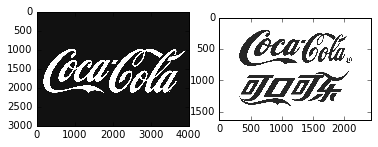

In [23]:
imgRef = cv2.imread('./Data/Reference/1.jpg', 0) #1 is colour, 0 is greyscale, -1 is unchanged
imgTest = cv2.imread('./Data/Test/2.jpg', 0)
#print imgRef
#plt.imshow(imgRef) #??? Why such a strange colour???

fig = plt.figure()
plt.subplot(121)
plt.imshow(imgRef, cmap='gray')
plt.subplot(122)
plt.imshow(imgTest, cmap='gray')
plt.show()

## ORB (Oriented FAST and Rotated BRIEF)

In [24]:
# Create an ORB object
orb = cv2.ORB() 

#detect key points
kpRef, descRef = orb.detectAndCompute(imgRef, None)
kpTest, descTest = orb.detectAndCompute(imgTest, None)

Draw key points detected.

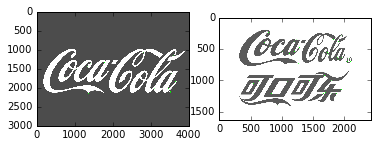

In [25]:
# draw only keypoints location,not size and orientation
imgRef_kp = cv2.drawKeypoints(imgRef,kpRef,color=(0,255,0), flags=0)
imgTest_kp = cv2.drawKeypoints(imgTest,kpTest,color=(0,255,0), flags=0)

fig = plt.figure()
plt.subplot(121)
plt.imshow(imgRef_kp)
plt.subplot(122)
plt.imshow(imgTest_kp)
plt.show()

## Alternative to drawMatches
In opencv2 has no cv2.drawMatches() module.

ref: https://gist.github.com/CannedYerins/11be0c50c4f78cad9549

In [13]:
def draw_matches(img1, kp1, img2, kp2, matches, color=None): 
    """Draws lines between matching keypoints of two images.  
    Keypoints not in a matching pair are not drawn.
    Places the images side by side in a new image and draws circles 
    around each keypoint, with line segments connecting matching pairs.
    You can tweak the r, thickness, and figsize values as needed.
    Args:
        img1: An openCV image ndarray in a grayscale or color format.
        kp1: A list of cv2.KeyPoint objects for img1.
        img2: An openCV image ndarray of the same format and with the same 
        element type as img1.
        kp2: A list of cv2.KeyPoint objects for img2.
        matches: A list of DMatch objects whose trainIdx attribute refers to 
        img1 keypoints and whose queryIdx attribute refers to img2 keypoints.
        color: The color of the circles and connecting lines drawn on the images.  
        A 3-tuple for color images, a scalar for grayscale images.  If None, these
        values are randomly generated.  
    """
    # We're drawing them side by side.  Get dimensions accordingly.
    # Handle both color and grayscale images.
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    r = 15
    thickness = 2
    if color:
        c = color
    for m in matches:
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(img1.shape) == 3 else np.random.randint(0,256)
        # So the keypoint locs are stored as a tuple of floats.  cv2.line(), like most other things,
        # wants locs as a tuple of ints.
        end1 = tuple(np.round(kp1[m.trainIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.queryIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        cv2.line(new_img, end1, end2, c, thickness)
        cv2.circle(new_img, end1, r, c, thickness)
        cv2.circle(new_img, end2, r, c, thickness)
    
    plt.figure(figsize=(15,15))
    plt.imshow(new_img)
    plt.show()

## Another Alternative to drawMatches()

Ref: http://stackoverflow.com/questions/20259025/module-object-has-no-attribute-drawmatches-opencv-python


In [14]:
import numpy as np
import cv2
%matplotlib inline

def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)


    # Show the image
    cv2.imshow('Matched Features', out)
    cv2.waitKey(0)
    cv2.destroyWindow('Matched Features')

    # Also return the image if you'd like a copy
    return out

## Matching I: Brute Force Matching

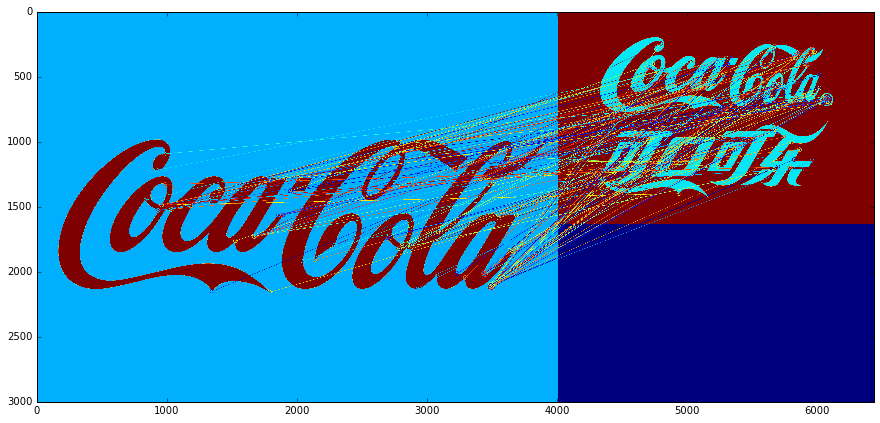

In [26]:
# create a BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descRef, descTest) # can try bf.knnMatch()

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Alternative ONE
draw_matches(imgRef,kpRef,imgTest,kpTest,matches)


In [17]:
# Alternative TWO
# Sort the matches based on distance.
# matches = sorted(matches, key=lambda val: val.distance)
# out = drawMatches(imgRef,kpRef,imgTest,kpTest,matches)

## Matching II: FLANN

This is not the right way.

See http://stackoverflow.com/questions/23634730/opencv-flann-matcher-crashes

Try to use KD-Tree or KMeans? Only for CV_32F descriptors like SIFT or SURF. For binary descriptors like BRIEF\ORB\FREAK you have to use either LSH or Hierarchical clustering index. Or simple bruteforce search. 


In [22]:
FLANN_INDEX_LSH = 1; 
index_params= dict(algorithm = FLANN_INDEX_LSH, 
                    table_number = 6, # 12
                    key_size = 12,     # 20
                    multi_probe_level = 1) #2

search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descRef, descTest, k=3) 

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]

 # ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                    singlePointColor = (255,0,0),
                    matchesMask = matchesMask,
                    flags = 0)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

error: ..\..\..\modules\flann\src\miniflann.cpp:315: error: (-210) type=0
 in function cv::flann::buildIndex_
